In [1]:
import pandas as pd
import numpy as np

stock_file = pd.read_csv("01-삼성전자-주가.csv")
stock_file['일자'] = pd.to_datetime(stock_file['일자'], format='%Y%m%d')


In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
stock_scaled = scaler.fit_transform(stock_file[scale_cols])
stock_scaled = pd.DataFrame(stock_scaled)

stock_scaled.columns = ['Open','High','Low','Close','trading value']
stock_scaled.insert(0,'Date', stock_file['일자'])

In [3]:
stock_scaled.head(10)

,Date,Open,High,Low,Close,trading value
0,2020-01-07,0.968632,0.980489,0.979522,0.975133,0.030291
1,2020-01-06,0.954691,0.966553,0.961868,0.969880,0.031470
2,2020-01-03,0.973860,0.983973,0.967164,0.969880,0.047217
3,2020-01-02,0.965147,0.973521,0.968929,0.964626,0.039781
4,2019-12-30,0.977346,0.983973,0.981287,0.975133,0.025585
5,2019-12-27,0.968632,0.989199,0.977756,0.987391,0.037698
6,2019-12-26,0.951206,0.963069,0.958337,0.968128,0.029530
7,2019-12-24,0.966890,0.968295,0.965399,0.961124,0.036337
8,2019-12-23,0.975603,0.980489,0.970695,0.969880,0.030124
9,2019-12-20,0.975603,0.982231,0.979522,0.978635,0.037032


In [4]:
#7일 기반으로 내일 데이터를 예측하는 경우
TEST_SIZE = 200
WINDOW_SIZE = 7

#testsize-> 잘 예측 되었는지 확인하기 위해 나눈것
train = stock_scaled[:-TEST_SIZE]
test = stock_scaled[-TEST_SIZE:]

In [5]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [6]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open','High','Low','trading value']#예측에 사용할 독립변수
label_cols = ['Close']#예측할 종속변수

#학습에 사용할 독립변수와 종속변수 설정
train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((7254, 20, 4), (1814, 20, 4))

In [7]:
#학습된 결과의 정확도를 보기위해
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 4), (200, 1))

In [8]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 4), (180, 1))

In [9]:
#keras로 모델 만들기

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [10]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
453/454 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 1: val_loss improved from inf to 0.00006, saving model to model\tmp_checkpoint.h5
454/454 [==============================] - 6s 9ms/step - loss: 0.0041 - val_loss: 5.9721e-05
Epoch 2/200
453/454 [============================>.] - ETA: 0s - loss: 7.0106e-05
Epoch 2: val_loss did not improve from 0.00006
454/454 [==============================] - 4s 9ms/step - loss: 7.0173e-05 - val_loss: 7.9160e-05
Epoch 3/200
453/454 [============================>.] - ETA: 0s - loss: 6.1990e-05
Epoch 3: val_loss improved from 0.00006 to 0.00005, saving model to model\tmp_checkpoint.h5
454/454 [==============================] - 4s 8ms/step - loss: 6.2166e-05 - val_loss: 4.9570e-05
Epoch 4/200
454/454 [==============================] - ETA: 0s - loss: 5.8795e-05
Epoch 4: val_loss improved from 0.00005 to 0.00004, saving model to model\tmp_checkpoint.h5
454/454 [==============================] - 4s 8ms/step - loss: 5.8795e

In [11]:
#예측결과 - weight와 예측값 보기
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

6/6 [==============================] - 0s 5ms/step


(180, 1)

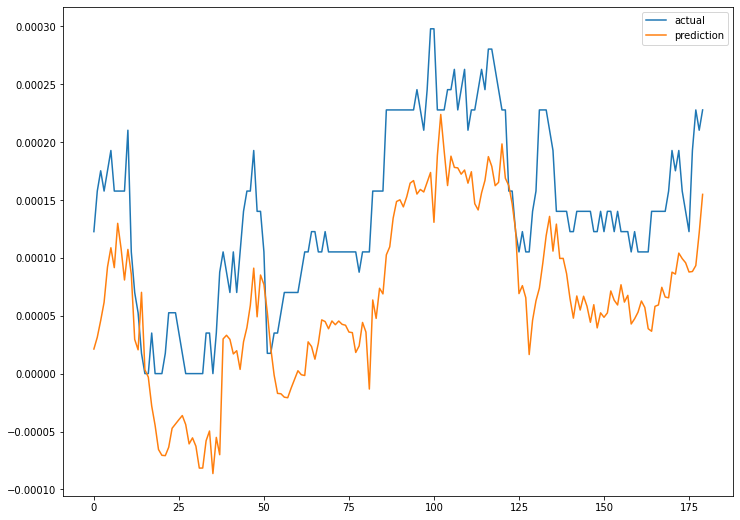

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [14]:
import sys

print(sys.version)

import tensorflow as tf
print(tf.__version__)


3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
2.10.0
